                            Statistical Data Analysis of Cosmic Ray

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss
from scipy.optimize import curve_fit
import emcee
import corner

 In this project we are analysing cosmic ray data from Cosmic Ray Database at http://lpsc.in2p3.fr/crdb/.
 All the data is recorded from many experiments that measure the flux of Galactic cosmic rays
 at the top of the atmosphere as a function of energy. For the data selection I have selected H
 as the element, ‘EKN (kinetic energy per nucleon)’ as the energy axis, and 1 GeV as the energy
 cutoff. Data is downloaded in the format of (.tar.gz) file after extracting the data in a specific
 folder where we can see 1 to 144 data exp file which contains the cosmic ray data and in data
 exps file contains experiment names by which data is generated.

 Three data columns we are interested in, one is mean energy < E > (GeV/n), and y is the flux
 with unit GeV−1 m−2 sr−1 s−1 and the third one I have created as mean error of flux,
 yerrtot mean = (yerrtot lo + yerrtot up)/2

In [3]:
headers = ['Qty','<E>','Elo','Eup','y','ystat_lo','ystat_up','ysyst_lo','ysyst_up','yerrtot_lo','yerrtot_up']
li = []
for i in range(1,145):
    project = pd.read_csv('data_exp{}.dat'.format(i), header=None).iloc[:1].values[0,0]
    df = pd.read_csv('data_exp{}.dat'.format(i), names=headers, delimiter=' ', skiprows=[0,1])
    li.append(df)
df = pd.concat(li, axis = 0, ignore_index=True)
df['yerrtot_mean'] = (df['yerrtot_lo']+df['yerrtot_up'])/2
df.head()

,Qty,<E>,Elo,Eup,y,ystat_lo,ystat_up,ysyst_lo,ysyst_up,yerrtot_lo,yerrtot_up,yerrtot_mean
0,H,1.76375,1.54,2.02,533.00000,1.20000,1.20000,24.094800,24.094800,24.124660,24.124660,24.124660
1,H,1.33079,1.15,1.54,738.00000,1.80000,1.80000,33.675100,33.675100,33.723170,33.723170,33.723170
2,H,179.54900,162.00,199.00,0.00939,0.00018,0.00018,0.001092,0.001092,0.001107,0.001107,0.001107
3,H,146.23300,132.00,162.00,0.01640,0.00027,0.00027,0.001109,0.001109,0.001142,0.001142,0.001142
4,H,119.39800,108.00,132.00,0.02900,0.00040,0.00040,0.001740,0.001740,0.001786,0.001786,0.001786


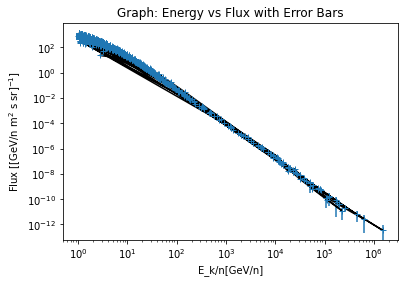

In [4]:
#log-log plot between flux and mean energy
plt.errorbar(np.array(df['<E>']), np.array(df['y']), yerr=np.array(df['yerrtot_mean']), fmt='+')
plt.loglog(np.array(df['<E>']), np.array(df['y']), color='black') 

plt.xlabel("E_k/n[GeV/n]")
plt.ylabel("Flux [$\mathrm{[GeV/n\ m^2\ s\ sr]^{-1}}$]")
plt.title("Graph: Energy vs Flux with Error Bars")
plt.show()

Now we will be plotting the log-log plot of flux as a function of energy in GeV, color-coded
by experiment.
Experiment names are in a different file named data_exps.txt
first we have to concat the experiment with relevent data in a single dataframe
then we can plot the clour plot

In [5]:
# Read the text file, skipping the first row
data_exps = pd.read_csv(r"C:\Users\91912\Desktop\MCMC\Full Stat Project\data_exps.txt", header=None, skiprows=[0], delimiter="\s+", engine='python')

# Extract the relevant columns
data_exps = data_exps.iloc[1:, [0, 2]]

# Reset the index
data_exps.reset_index(drop=True, inplace=True)
# Remove the "files/805689962/" part from the first column
data_exps.iloc[:, 0] = data_exps.iloc[:, 0].str.replace('files/805689962/', '')

# Rename the columns
data_exps.columns = ['File', 'Ex']

# Save as CSV file
data_exps.to_csv("data_exps.csv", index=False)

print(data_exps.head())

            File        Ex
0  data_exp1.dat     AMS01
1  data_exp2.dat  BESS-TeV
2  data_exp3.dat    BESS00
3  data_exp4.dat    BESS93
4  data_exp5.dat    BESS94


In [6]:
# Read the text file, skipping the first row
data_exps = pd.read_csv(r"C:\Users\91912\Desktop\MCMC\Full Stat Project\data_exps.txt", header=None, skiprows=[0], delimiter="\s+", engine='python')

# Extract the relevant columns
data_exps = data_exps.iloc[1:, [0, 2]]

data_exps.reset_index(drop=True, inplace=True)

# Remove the "files/805689962/" part from the first column for analysis
data_exps.iloc[:, 0] = data_exps.iloc[:, 0].str.replace('files/805689962/', '')

data_exps.columns = ['File', 'Ex']

# Import data_exp files and add experiment name
headers = ['Qty', '<E>', 'Elo', 'Eup', 'y', 'ystat_lo', 'ystat_up', 'ysyst_lo', 'ysyst_up', 'yerrtot_lo', 'yerrtot_up']
li = []
for i in range(1, 145):
    file_name = f'data_exp{i}.dat'
    experiment_name = data_exps[data_exps['File'] == file_name]['Ex'].values
    if len(experiment_name) > 0:
        experiment_name = experiment_name[0]
    else:
        experiment_name = 'Unknown'  # Assign a default value or handle it according to your needs
    df = pd.read_csv(file_name, names=headers, delimiter=' ', skiprows=[0, 1])
    df['EXP'] = experiment_name
    li.append(df)
df = pd.concat(li, axis=0, ignore_index=True)
df['yerrtot_mean'] = (df['yerrtot_lo'] + df['yerrtot_up']) / 2
df= df[['<E>', 'y', 'yerrtot_mean', 'EXP']]
print(df.head())

         <E>          y  yerrtot_mean    EXP
0    1.76375  533.00000     24.124660  AMS01
1    1.33079  738.00000     33.723170  AMS01
2  179.54900    0.00939      0.001107  AMS01
3  146.23300    0.01640      0.001142  AMS01
4  119.39800    0.02900      0.001786  AMS01


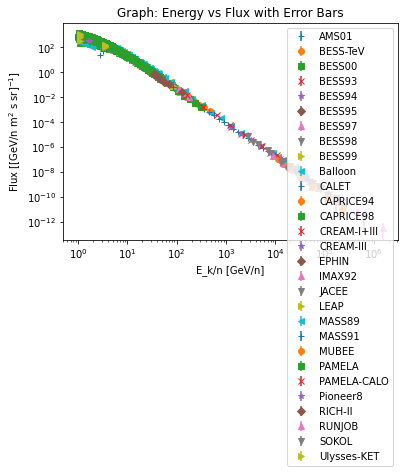

In [7]:
fig, ax = plt.subplots()

# Define marker styles for different experiments
marker_styles = ['+', 'o', 's', 'x', '*', 'D', '^', 'v', '>', '<']

# Group the data by experiment name
grouped_data = df.groupby('EXP')

for i, (name, group) in enumerate(grouped_data):
    marker = marker_styles[i % len(marker_styles)]
    ax.errorbar(np.array(group['<E>']), np.array(group['y']), yerr=np.array(group['yerrtot_mean']), fmt=marker, label=name)
ax.set_xlabel("E_k/n [GeV/n]")
ax.set_ylabel("Flux [$\mathrm{[GeV/n\ m^2\ s\ sr]^{-1}}$]")
ax.set_title("Graph: Energy vs Flux with Error Bars")
ax.set_xscale("log")
ax.set_yscale("log")

ax.legend()
plt.show()


Mean cosmic ray flux between 20 and 30 GeV and the error on the mean.

In [8]:
flux_new = df[(df['<E>'] > 20) & (df['<E>'] < 30)]
mean_flux = flux_new['y'].mean()
# the weighted mean and weighted standard error
weighted_mean_flux = np.average(flux_new['y'], weights=(1 / flux_new['yerrtot_mean'] ** 2))
error_mean_flux = np.sqrt(1 / np.sum(1 / flux_new['yerrtot_mean'] ** 2))

print('Mean Cosmic Ray Flux:', "{:.4f}".format(mean_flux))
print('Error on the Mean(Weighted mean):', "{:.4f}".format(error_mean_flux))

Mean Cosmic Ray Flux: 2.1138
Error on the Mean(Weighted mean): 0.0058


Power law curve fitting and chi2 values. 
we will be fitting a power law $F = F_0 E^{-p}$ where p is called the power-law index ($p > 0$ in this case) and $F_0$ is the
normalization constant.
At low energies, the cosmic ray flux is reduced due to interactions
with the solar wind so we have selected E$>$24 .
$F_0$=14467.536248519795
p=2.749200461426135
And after the powerlaw fitting $\chi^2$ value is 1362.7300012157436.
Number of degrees of freedom is 788.
Result is showing a poor fit after the curve fit, result and graph is shown bellow.

In [9]:
#Creating model
# Define the power-law model
def model(E, F0, p):
    return F0 * np.power(E, -p)

#Energy and Flux of selected Energy threshold
energy=df['<E>']
flux=df['y']
error=df['yerrtot_mean']
ene=df['<E>']>24
ene_lim=energy[ene]
flux_lim=flux[ene]
err_lim=error[ene]
p0 = [200.0, 1] #initial guess
popt,pcov=curve_fit(model,ene_lim,flux_lim,p0)
popt[0],popt[1]

(14467.536248519795, 2.749200461426135)

number of degrees of freedom is 788
value of chi^2 at best fit is 1362.7300012157436
pvalue is 2.2999198895100008e-33


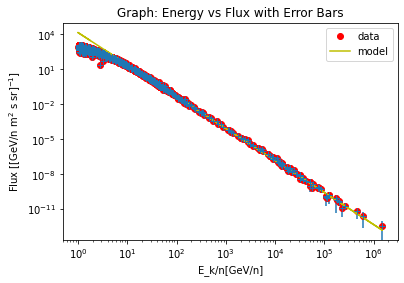

pvalue is 2.2999198895100008e-33
null hypothesis is rejected, poor fit


In [10]:
def mychi2(F0, p, E, y, yerr):
    return np.sum((y - model(E, F0, p)) ** 2 / yerr ** 2)

ndof = len(ene_lim) - 2  # no of fitted parameters is 2
print('number of degrees of freedom is', ndof)
chi2best = mychi2(popt[0], popt[1], np.array(ene_lim), np.array(flux_lim), np.array(err_lim))
pvalue = ss.chi2(ndof).sf(chi2best) 
print('value of chi^2 at best fit is', chi2best)
alpha = 0.05
print('pvalue is', pvalue)
plt.loglog(np.array(df['<E>']), np.array(df['y']), "ro", label="data")
plt.loglog(np.array(df['<E>']), model(np.array(df['<E>']), popt[0], popt[1]), "y-", label="model")
plt.errorbar(np.array(df['<E>']), np.array(df['y']), yerr=np.array(df['yerrtot_mean']), fmt='+')
plt.xlabel("E_k/n[GeV/n]")
plt.ylabel("Flux [$\mathrm{[GeV/n\ m^2\ s\ sr]^{-1}}$]")
plt.title("Graph: Energy vs Flux with Error Bars")
plt.legend()
plt.show()
print('pvalue is', pvalue) 

if pvalue > alpha:
    print('cannot reject the null hypothesis, good fit')
else:
    print('null hypothesis is rejected, poor fit')


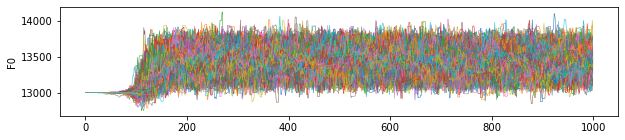

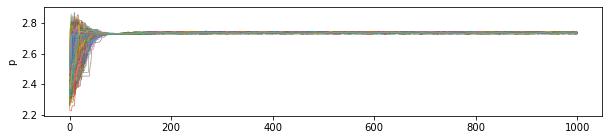

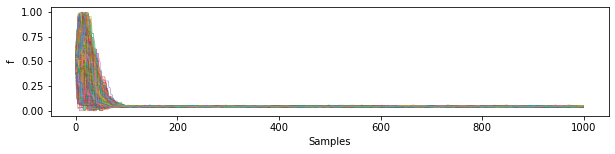

Too few points to create valid contours


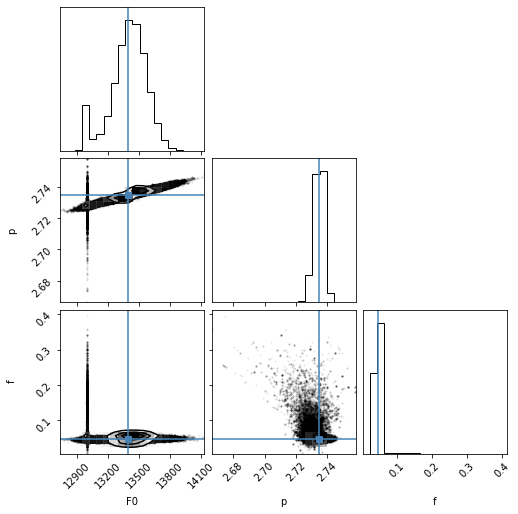

MCMC mean parameters: F0 13396.702320369635 p 2.7347196236462477 f 0.045950957165908


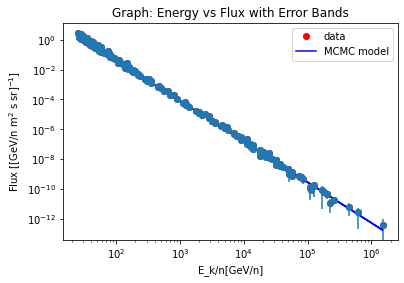

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner

def model(E, F0, p):
    return F0 * E ** -p

def ermod(params, y, err):
    F0, p, f = params
    return np.sqrt((f * y)**2 + err**2)

def lnprior(params):
    F0, p, f = params
    if 10000. < F0 < 15000. and 2. < p < 4. and 0 < f < 1.:
        return np.log(1.0/F0) + np.log(1.0/f)
    return -np.inf

def lnlike(params, x, y, err):
    F0, p, f = params
    model_value = model(x, F0, p)
    err_value = ermod(params, y, err)
    return -0.5 * np.sum((y - model_value)**2 / err_value**2 + np.log(err_value**2))

def lnpost(params, x, y, err):
    lp = lnprior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(params, x, y, err)

energy=df['<E>']
flux=df['y']
error=df['yerrtot_mean']
ene=df['<E>']>24
ene_lim=energy[ene]
flux_lim=flux[ene]
err_lim=error[ene]
nwalkers = 1000
ndim = 3
F0_guess = 13000.
p_guess = 2.4
f_guess = 0.5
pos = [np.array([F0_guess, p_guess, f_guess]) + 0.05*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnpost, args=(ene_lim, flux_lim, err_lim))
sampler.run_mcmc(pos, 1000)
labels = ['F0', 'p', 'f']
for i in range(ndim):
    plt.figure(figsize=(10, 2))
    plt.plot(sampler.chain[:, :, i].T, lw=0.5)
    plt.ylabel(labels[i])
plt.xlabel('Samples')
plt.show()
samples = sampler.chain[:, 50:, :].reshape((-1, ndim)) # discard burn-in
F0_mcmc, p_mcmc, f_mcmc = np.mean(samples, axis=0)
corner.corner(samples, labels=labels, truths=[F0_mcmc, p_mcmc, f_mcmc])
plt.show()
# Print MCMC results
print('MCMC mean parameters: F0', F0_mcmc, 'p', p_mcmc, 'f', f_mcmc)
# uncertainties
F0_std, p_std, f_std = np.std(samples, axis=0)

# data PLOT
plt.loglog(np.array(ene_lim), np.array(flux_lim), "ro", label="data")
plt.errorbar(np.array(ene_lim), np.array(flux_lim), yerr=np.array(err_lim), fmt='o')
# MCMC model
plt.loglog(np.array(ene_lim), model(np.array(ene_lim), F0_mcmc, p_mcmc), "b-", label="MCMC model")
# Adding error bands to the MCMC model plot
flux_mcmc_high = model(ene_lim, F0_mcmc + F0_std, p_mcmc + p_std)
flux_mcmc_low = model(ene_lim, F0_mcmc - F0_std, p_mcmc - p_std)
plt.fill_between(ene_lim, flux_mcmc_low, flux_mcmc_high, color='blue', alpha=0.3)
plt.xlabel("E_k/n[GeV/n]")
plt.ylabel("Flux [$\mathrm{[GeV/n\ m^2\ s\ sr]^{-1}}$]")
plt.title("Graph: Energy vs Flux with Error Bands")
plt.legend()
plt.show()